
<h3> Welcome to the YOLOv12 Finetuning Notebook. (Comic Panel Detection)</h3>
<br>
In this notebook, I finetune the Ultralytics <a href="https://github.com/ultralytics/ultralytics">YOLOv12</a>

YOLOv12 is the latest version of the YOLO (You Only Look Once) AI models developed by Ultralytics.

YOLO12 models are fast, accurate, and easy to use, making them ideal for various object detection and image segmentation tasks. They can be trained on large datasets and run on diverse hardware platforms, from CPUs to GPUs.


This notebook shows the process of training and testing a finetuned model.
</div>

# Setup
To make it easier to manage datasets, images and models, we create a HOME constant

In [1]:
import os
HOME = os.getcwd()
print(HOME)

/workspace



Pip install ultralytics, pytorch and other dependencies

In [2]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
Setup complete ✅ (64 CPUs, 251.5 GB RAM, 0.7/20.0 GB disk)


In [3]:
import torch

DEVICE = "cpu"

print("CUDA available:", torch.cuda.is_available())

if torch.cuda.is_available():
  print("Current device:", torch.cuda.current_device())
  print("Device name:", torch.cuda.get_device_name(0))
  DEVICE = torch.cuda.current_device()


CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 3090


In [4]:
pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 23.3.1
    Uninstalling pip-23.3.1:
      Successfully uninstalled pip-23.3.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install opencv-python matplotlib numpy pyyaml pillow requests pandas

Note: you may need to restart the kernel to use updated packages.


# 1. Download model

Download the YOLO12 model


In [6]:
from ultralytics import YOLO
# 'yolov12x.pt' is the largest version of YOLOv12
model = YOLO("yolo12x.pt")
print(model)

100%|██████████| 114M/114M [00:01<00:00, 67.2MB/s] 


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

Test the YOLO12 model by performing a prediction

In [7]:
# Run inference with YOLO
results = model.predict(source="https://ultralytics.com/images/zidane.jpg", save=True, project='my_yolo_train', name='demonstration')

# get the data of the first inference prediction
print(results[0].orig_shape)
output_image = results[0].orig_img
output_image_dir = results[0].save_dir
input_image_path = results[0].path
print(output_image_dir)
print(input_image_path)

100%|██████████| 49.2k/49.2k [00:00<00:00, 14.7MB/s]


image 1/1 /workspace/zidane.jpg: 384x640 2 persons, 2 ties, 150.7ms
Speed: 4.8ms preprocess, 150.7ms inference, 103.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to my_yolo_train/demonstration
(720, 1280)
my_yolo_train/demonstration
/workspace/zidane.jpg


Display the image prediction

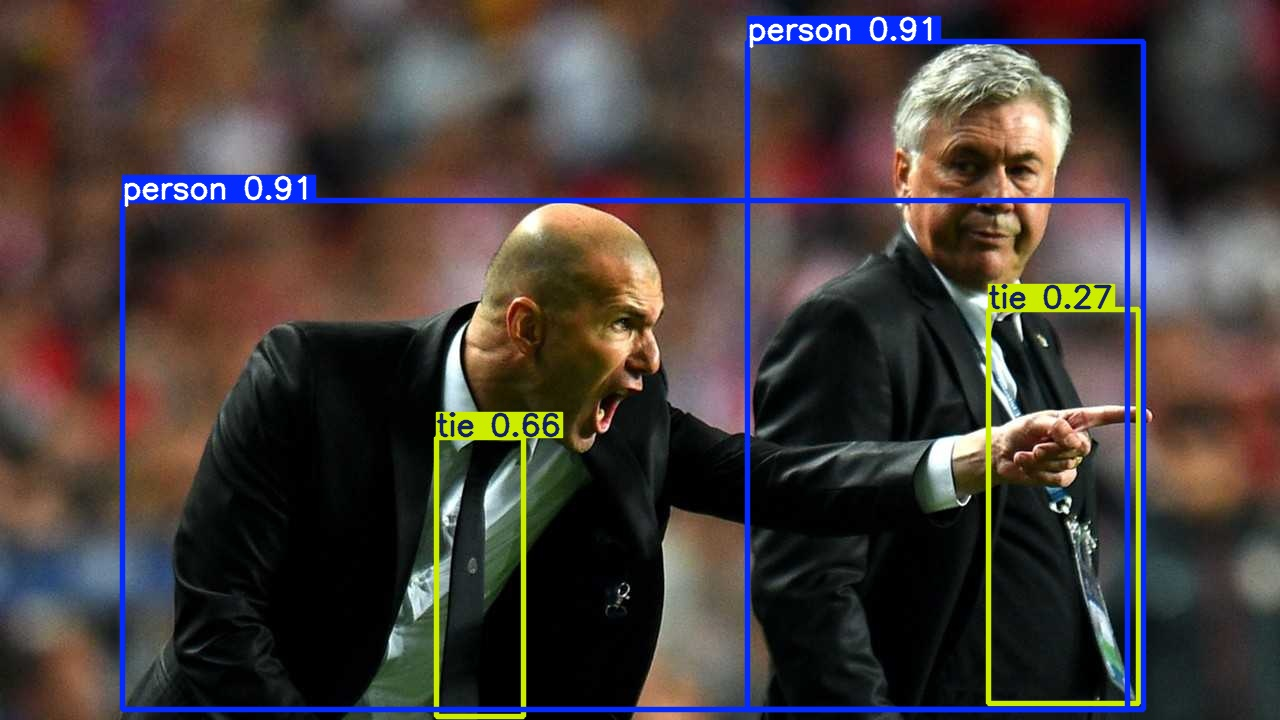

In [8]:
from IPython.display import Image as IPyImage

# Display the image
IPyImage(filename=f'{HOME}/{output_image_dir}/{os.path.basename(input_image_path)}', width=600)

# 2. Dataset Loading
Download and prepare my cleaned images dataset for yolo


In [ ]:

!mkdir {HOME}/datasets
%cd {HOME}/datasets

from roboflow import Roboflow

try:
    ROBOFLOW_API_KEY = "USE_YOUR_ROBOFLOW_API_KEY"
    rf = Roboflow(api_key=ROBOFLOW_API_KEY)
    
    project = rf.workspace().project("custom-workflow-3-object-detection-g24r5-fmfkb")
    version = project.version(1)
    dataset = version.download("yolov12")
except Exception as e:
    print(f"Failed to download the dataset: {e}")

%cd {HOME}

/workspace/datasets


/usr/local/lib/python3.10/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Custom-Workflow-3-Object-Detection-1 in yolov12:: 100%|██████████| 428/428 [00:00<00:00, 4690.29it/s]

/workspace


Verify the structure of the extracted files (this helps in understanding where train/val data is)

In [10]:
for root, dirs, files in os.walk(os.path.join(os.getcwd())):
    print(f'Found folder: {root} with {len(files)} files')

Found folder: /workspace with 3 files
Found folder: /workspace/.ipynb_checkpoints with 1 files
Found folder: /workspace/my_yolo_train with 0 files
Found folder: /workspace/my_yolo_train/demonstration with 1 files
Found folder: /workspace/datasets with 0 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1 with 3 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/test with 0 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/test/images with 8 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/test/labels with 8 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/train with 0 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/train/images with 183 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/train/labels with 183 files
Found folder: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/valid with 0 fil

Display a grid of image samples from the dataset with data annotation

# 4. Train
model.train is used for training a YOLO12 model on a custom dataset. In this mode, the model is trained using the specified dataset and hyperparameters. The training process involves optimizing the model's parameters so that it can accurately predict the classes and locations of objects in an image.

In [12]:
# Train the YOLO model with the custom dataset
results = model.train(data=f"{dataset.location}/data.yaml", epochs=200, imgsz=640, batch=16, val=True, project='my_yolo_train', name='finetuning', 
                          save=True, device=[0, 1], cache=True, plots=True, exist_ok=True)

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
                                                        CUDA:1 (NVIDIA GeForce RTX 3090, 24253MiB)
engine/trainer: task=detect, mode=train, model=yolo12x.pt, data=/workspace/datasets/Custom-Workflow-3-Object-Detection-1/data.yaml, epochs=200, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=[0, 1], workers=8, project=my_yolo_train, name=finetuning, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, c

100%|██████████| 755k/755k [00:00<00:00, 36.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              


  6                  -1  4   9512128  ultralytics.nn.modules.block.A2C2f           [768, 768, 4, True, 4, True, 1.2]
  7                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  8                  -1  4   9512128  ultralytics.nn.modules.block.A2C2f           [768, 768, 4, True, 1, True, 1.2]
  9                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 10             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 11                  -1  2   4727040  ultralytics.nn.modules.block.A2C2f           [1536, 768, 2, False, -1, True, 1.2]
 12                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 13             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 14                  -1  2   1331328  ultralytics.nn.modules.block.A2C2f    

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.6MB/s]


AMP: checks passed ✅


train: Scanning /workspace/datasets/Custom-Workflow-3-Object-Detection-1/train/labels... 183 images, 51 backgrounds, 0 corrupt: 100%|██████████| 183/183 [00:00<00:00, 1067.26it/s]


train: New cache created: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/train/labels.cache
WARNING ⚠️ Box and segment counts should be equal, but got len(segments) = 609, len(boxes) = 621. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.2GB RAM): 100%|██████████| 183/183 [00:00<00:00, 2459.98it/s]
val: Scanning /workspace/datasets/Custom-Workflow-3-Object-Detection-1/valid/labels... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<00:00, 1116.10it/s]
val: Caching images (0.0GB RAM): 100%|██████████| 17/17 [00:00<00:00, 1405.29it/s]


val: New cache created: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.
Plotting labels to my_yolo_train/finetuning/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 205 weight(decay=0.0), 214 weight(decay=0.0005), 211 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 16 dataloader workers
Logging results to my_yolo_train/finetuning
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      13.2G      1.232      2.485      1.654         31        640: 100%|██████████| 12/12 [00:06<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.82it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      14.8G     0.8914      1.219      1.345         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      14.9G     0.7554        1.2      1.229         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      14.9G     0.8112     0.8939      1.242         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      14.9G      0.696     0.8896      1.178         33        640: 100%|██████████| 12/12 [00:04<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      14.9G     0.7182     0.8054      1.224         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      14.9G     0.8652     0.8525      1.302         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      14.9G     0.8006     0.8475      1.227         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      14.9G     0.7002     0.7685      1.193         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]


                   all         17         81       0.03     0.0864    0.00775     0.0017

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      14.9G     0.6206      0.701       1.12         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


                   all         17         81          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      14.9G     0.5741      0.698      1.082         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


                   all         17         81      0.369      0.469      0.331       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      14.9G      0.574      0.645       1.12         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


                   all         17         81      0.465       0.84      0.751      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      14.9G     0.5462     0.6121      1.084         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81      0.632      0.815      0.808      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      14.9G      0.543     0.6549      1.081         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81      0.767      0.974      0.945      0.792

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      14.9G     0.6018     0.6166      1.123         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.677      0.654      0.724      0.522

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      14.9G     0.5561     0.5899      1.073         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


                   all         17         81      0.712      0.617      0.657      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      14.9G      0.509     0.5487       1.08         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


                   all         17         81      0.157      0.556      0.151     0.0849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      14.9G      0.497     0.5412      1.049         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.709      0.661      0.744      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      14.9G     0.4964     0.5893      1.026         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.661      0.679       0.69      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      14.9G     0.4652     0.5306      1.035         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.468      0.753       0.63      0.401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      14.9G     0.4618     0.6684      1.052          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81       0.76      0.852      0.907      0.775

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      14.9G     0.4806     0.5303      1.052         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.40it/s]


                   all         17         81      0.735      0.823      0.826      0.583

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      14.9G      0.449     0.4779       1.01         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81       0.51      0.616      0.574      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      14.9G     0.4137     0.4712      1.008         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.936      0.975      0.977      0.824

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      14.9G     0.4067     0.4279      1.002         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.906      0.949      0.982      0.916

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      14.9G     0.4196     0.4874       1.01         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         17         81      0.943      0.963      0.978      0.899

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      14.9G     0.4281     0.4722      0.999         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.891      0.951      0.962       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      14.9G     0.4263     0.4791      1.022         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


                   all         17         81      0.909      0.986      0.984      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      14.9G     0.4384     0.4646      1.009         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.854      0.889      0.949      0.851

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      14.9G     0.4231     0.4449     0.9914         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.868      0.951      0.969       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      14.9G     0.3806     0.4152     0.9994         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.63it/s]


                   all         17         81      0.944      0.975      0.975      0.921

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      14.9G      0.372     0.4092     0.9991         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.911      0.975      0.963      0.918

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      14.9G      0.397     0.4523     0.9843         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.872      0.938      0.954      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      14.9G     0.3919     0.3954      1.004         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


                   all         17         81      0.966      0.951      0.989      0.941

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      14.9G     0.3751     0.4233     0.9784         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


                   all         17         81      0.984      0.988      0.989      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      14.9G     0.3997     0.4392      1.006         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.836      0.963      0.961      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      14.9G     0.4004     0.4441      1.003         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.873      0.931       0.96      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      14.9G     0.3645     0.4003     0.9818         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.823      0.926      0.942      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      14.9G     0.3997     0.4422     0.9897         40        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.909      0.926      0.966       0.91

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      14.9G      0.363     0.3915     0.9619         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


                   all         17         81      0.881      0.913      0.959      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      14.9G     0.3664     0.3595     0.9646         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.983      0.951      0.989      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      14.9G     0.3835     0.4331     0.9809         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.976      0.983      0.989      0.949

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      14.9G     0.3538     0.3934     0.9761         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.935      0.926      0.981      0.934

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      14.9G      0.364     0.3901     0.9901         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.995      0.975      0.991      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      14.9G     0.3668     0.3971     0.9742         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.999          1      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      14.9G     0.3407     0.3628     0.9679         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.986      0.975      0.988      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      14.9G     0.3437     0.3787     0.9689         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81       0.94       0.96      0.976      0.946

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      14.9G     0.3311     0.3253     0.9729         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.975      0.971       0.99       0.95

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      14.9G     0.3366       0.37     0.9614         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.972      0.975      0.993      0.948

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      14.9G     0.3436     0.3863      0.979         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.984      0.938      0.978       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      14.9G      0.334     0.3434     0.9548         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81       0.94      0.961      0.987      0.942

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      14.9G     0.3512     0.3948     0.9876         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


                   all         17         81      0.974      0.925      0.978      0.915

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      14.9G      0.332     0.3627     0.9609         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.943      0.938      0.978      0.925

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      14.9G     0.3555     0.3871     0.9581         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.998      0.988      0.991      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      14.9G     0.3959     0.4493     0.9972         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81      0.939       0.95      0.981      0.935

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      14.9G     0.3448     0.3623     0.9828         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.821      0.914      0.951      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      14.9G     0.3477     0.3746     0.9579         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81       0.93      0.987      0.991      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      14.9G     0.3273     0.3535     0.9299         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


                   all         17         81      0.921      0.963      0.986      0.945

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      14.9G     0.3192     0.3504     0.9506         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.937      0.975      0.986      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      14.9G     0.3138      0.337     0.9359         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81      0.961      0.951      0.987      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      14.9G     0.3471     0.3532     0.9492         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.975      0.974      0.988      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      14.9G     0.3295     0.3419     0.9527         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.981      0.951      0.986      0.944

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      14.9G      0.308     0.3452     0.9403         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.941      0.985      0.991      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      14.9G     0.3014     0.3542     0.9457         12        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81      0.983      0.963      0.993      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      14.9G     0.2894     0.3094     0.9116         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.997      0.975      0.986      0.936

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      14.9G     0.2955     0.3096     0.9234         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.988      0.987      0.992      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      14.9G      0.321     0.3231     0.9587         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.951      0.988       0.99      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      14.9G     0.3025     0.3188     0.9246         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.983      0.975      0.993      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      14.9G     0.3005     0.3217     0.9514         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.997      0.988      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      14.9G     0.3041     0.3157     0.9531         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


                   all         17         81          1      0.948      0.985      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      14.9G      0.303     0.3204     0.9204         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.983          1      0.995      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      14.9G      0.326     0.3374     0.9628         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81      0.964      0.999      0.993      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      14.9G      0.316     0.3388     0.9525         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81          1      0.999      0.995      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      14.9G     0.3026     0.3337     0.9532         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.988      0.982      0.994      0.958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      14.9G     0.3242     0.3412     0.9442         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.985      0.975      0.994      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      14.9G     0.3161     0.3421     0.9517         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


                   all         17         81      0.982      0.963      0.991      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      14.9G     0.2996     0.3132     0.9159         41        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81          1       0.96      0.992      0.974

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      14.9G     0.3028     0.3075     0.9409         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.986          1      0.995      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      14.9G     0.2844     0.3054     0.9241         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.996      0.975      0.994      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      14.9G      0.292     0.2961     0.9405         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.974      0.988      0.993      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      14.9G      0.312      0.316     0.9409         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.52it/s]


                   all         17         81      0.952          1      0.994      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      14.9G     0.3035     0.3004     0.9318         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         17         81      0.952          1      0.993      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      14.9G     0.2969     0.3422     0.9354         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.988      0.986      0.995      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      14.9G     0.3078     0.3165     0.9328         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81          1      0.974      0.993      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      14.9G     0.2834     0.2756     0.9223         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.996      0.938       0.99      0.969

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      14.9G     0.2887     0.2752      0.927         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81       0.94      0.975       0.99      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      14.9G     0.3034     0.3281     0.9477         30        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


                   all         17         81      0.997      0.975      0.994      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      14.9G     0.2818     0.2978     0.9492         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.997      0.975      0.994      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      14.9G      0.278     0.3025     0.9221         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81          1      0.924      0.985      0.932

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      14.9G     0.2637     0.2672     0.9116         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.942          1      0.992      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      14.9G     0.2706     0.2689      0.916         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


                   all         17         81      0.875      0.949      0.972      0.898

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      14.9G     0.2635     0.2894     0.9029         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.905      0.938      0.968      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      14.9G     0.2709     0.2945     0.9127         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81          1      0.986      0.995      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      14.9G     0.2697     0.2886     0.9247         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


                   all         17         81          1      0.986      0.989      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      14.9G     0.2666     0.3132     0.9299         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.987      0.973      0.986      0.955

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      14.9G      0.257     0.2692     0.9125         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


                   all         17         81      0.939      0.988      0.983      0.957

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      14.9G     0.2731     0.3042     0.9261         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.955      0.975      0.984      0.952

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      14.9G     0.2552     0.2646     0.9172         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.984      0.963      0.986      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      14.9G     0.2837     0.2587     0.9272         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.975      0.975      0.984       0.97

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      14.9G     0.2628     0.2798     0.9066         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.47it/s]


                   all         17         81      0.974          1      0.995      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      14.9G     0.2488     0.2664        0.9         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.999      0.988      0.995       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      14.9G     0.2497     0.2852     0.9155         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.988      0.982      0.994       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      14.9G     0.2282      0.243     0.8805         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.43it/s]


                   all         17         81      0.975      0.949       0.99      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      14.9G     0.2636     0.2668     0.8993         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.998      0.938      0.984      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      14.9G     0.2361     0.2483     0.8994         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81          1      0.971       0.99      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      14.9G     0.2556     0.2435     0.9043         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


                   all         17         81      0.985      0.988       0.99      0.975

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      14.9G     0.2382     0.2397     0.8925         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.969      0.975      0.982      0.965

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      14.9G     0.2607      0.286     0.9034         43        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.975       0.96      0.984      0.966

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      14.9G     0.2448     0.2524     0.9004         46        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


                   all         17         81      0.994      0.963      0.986      0.953

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      14.9G     0.2301     0.2436     0.8926         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81          1      0.986      0.989      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      14.9G     0.2355     0.2525     0.8982         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81          1      0.986      0.989      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      14.9G     0.2452     0.2608     0.9015         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81      0.987      0.988      0.987      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      14.9G     0.2161     0.2354     0.8818         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.997      0.988      0.987      0.962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      14.9G     0.2391     0.2369     0.9044         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.998      0.988      0.988      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      14.9G      0.257     0.2588      0.915         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.998      0.988      0.988      0.968

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      14.9G     0.2596     0.2637     0.9129         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.988      0.987      0.988      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      14.9G     0.2416     0.2361     0.9037         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.976      0.986      0.988      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      14.9G     0.2446     0.2488     0.9057         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         17         81      0.964      0.987      0.993      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      14.9G     0.2129     0.2486     0.8909         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.988      0.986      0.994      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      14.9G     0.2155     0.2549     0.9087         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.987       0.97      0.993      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      14.9G     0.2175     0.2278     0.8967         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.947      0.992       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      14.9G     0.2402     0.2676     0.9241         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.987      0.974      0.992      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      14.9G     0.2353     0.2367     0.8958         41        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         17         81      0.987      0.962      0.989       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      14.9G     0.2272      0.223     0.8962         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


                   all         17         81      0.975      0.963      0.985      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      14.9G     0.2177     0.2319     0.9113         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.975      0.975      0.986      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      14.9G     0.2173     0.2568     0.8975         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.988      0.986      0.989      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      14.9G     0.2321     0.2421     0.8938         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81          1      0.986      0.994       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      14.9G     0.2358       0.25     0.9177         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81      0.999      0.988      0.994      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      14.9G     0.2283     0.2448     0.9224         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.974      0.988      0.993       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      14.9G     0.2285       0.25     0.9034         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


                   all         17         81          1          1      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      14.9G     0.2111     0.2422     0.9009         18        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.975      0.974      0.993      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      14.9G      0.224     0.2362     0.9123         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.976      0.999      0.994      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      14.9G     0.2252     0.2549     0.9062         37        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.988      0.983      0.995      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      14.9G     0.2162     0.2344     0.8906         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.964      0.999      0.994      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      14.9G     0.2353      0.231     0.9227         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.988      0.987      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      14.9G     0.2096     0.2134     0.8878         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.998          1      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      14.9G     0.2166     0.2397     0.9195         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.997      0.988      0.989      0.973

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      14.9G     0.2314     0.2401     0.9244         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.952      0.987      0.986      0.947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      14.9G     0.2075     0.2239      0.886         25        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.972      0.975       0.98      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      14.9G     0.2024     0.2211     0.8828         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.975      0.974      0.987      0.964

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      14.9G     0.2263     0.2514     0.9263         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.975      0.988      0.989      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      14.9G     0.2165     0.2286     0.9024         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.46it/s]


                   all         17         81      0.973      0.975      0.988      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      14.9G     0.2132     0.2222     0.9038         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.964      0.986      0.987      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      14.9G     0.2136     0.2269     0.8878         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.962      0.988      0.987      0.976

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      14.9G     0.1916     0.2038     0.8658         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81       0.95      0.988      0.986      0.971

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      14.9G     0.1802     0.1946     0.8672         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.986      0.963      0.988      0.961

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      14.9G     0.1964     0.1956     0.8849         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.975      0.962      0.985      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      14.9G     0.1965     0.2083     0.8783         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


                   all         17         81          1      0.962       0.99      0.963

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      14.9G     0.2021     0.2227     0.8892         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81      0.998      0.975       0.99      0.972

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      14.9G     0.1907     0.2038     0.8863         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.976      0.987      0.989      0.977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      14.9G     0.2014     0.2263     0.9069         35        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.66it/s]


                   all         17         81      0.987      0.988      0.989       0.98

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      14.9G     0.2059     0.2388     0.9075         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.999      0.988       0.99      0.978

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      14.9G     0.1847     0.2004     0.8843         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.988      0.987      0.989      0.979

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      14.9G     0.2012     0.2103     0.8834         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81          1      0.988      0.992      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      14.9G     0.1945     0.2133     0.8897         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.999      0.975      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      14.9G     0.1993     0.2239     0.8839         22        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.987      0.988      0.994       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      14.9G     0.1896     0.1993     0.8928         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.975      0.988      0.994      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      14.9G     0.2043     0.2122     0.9091         14        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.988      0.998      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      14.9G     0.1902     0.1944     0.8878         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.987      0.988      0.993      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      14.9G     0.1835     0.1974      0.878         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.50it/s]


                   all         17         81          1      0.988      0.994      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      14.9G      0.186     0.2075     0.8766         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.62it/s]


                   all         17         81          1      0.987      0.993      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      14.9G      0.182     0.1995     0.8954         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.999      0.975      0.994      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      14.9G     0.2008     0.2117     0.8987         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.998      0.988      0.995      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      14.9G     0.1909     0.1884     0.8808         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81          1      0.973      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      14.9G     0.1943     0.1978     0.8996         31        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.998      0.975      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      14.9G       0.18     0.1957     0.8667         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.987      0.973      0.994      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      14.9G     0.2039     0.2113     0.9014         27        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.976      0.996      0.994      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      14.9G     0.1876     0.1761     0.8782         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.984          1      0.994      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      14.9G      0.186     0.2024     0.8854         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.987          1      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      14.9G     0.1847     0.1774     0.8861         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.987          1      0.995      0.989

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      14.9G     0.1815     0.1811     0.8888         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.988      0.995       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      14.9G     0.1713     0.1676     0.8774         28        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


                   all         17         81      0.986      0.988      0.991      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      14.9G     0.1634     0.1697     0.8788         43        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.56it/s]


                   all         17         81      0.985      0.988      0.991      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      14.9G     0.1881     0.1984     0.8868         23        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.975      0.991      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      14.9G     0.1645     0.1729     0.8702         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.975       0.99      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      14.9G     0.1639     0.1696     0.8754         29        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.54it/s]


                   all         17         81      0.985      0.988       0.99      0.987

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      14.9G      0.166     0.1744     0.8668         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.988       0.99      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      14.9G     0.1651       0.18     0.8708         42        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.53it/s]


                   all         17         81      0.988      0.987      0.992      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      14.9G     0.1734     0.1724      0.864         50        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.988      0.987      0.989      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      14.9G     0.1734     0.1866     0.8659         39        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.987      0.988      0.989      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      14.9G     0.1615     0.1745     0.8808         20        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.985      0.988      0.988      0.983

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      14.9G     0.1629     0.1591     0.8713         34        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.987      0.974      0.988      0.982

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      14.9G     0.1661     0.1651     0.8797         32        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


                   all         17         81      0.987      0.975      0.988      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      14.9G     0.1651     0.1705     0.8718         38        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.988      0.986      0.989      0.984

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      14.9G     0.1751     0.1812      0.889         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81      0.988      0.986      0.988      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      14.9G     0.1619     0.1658     0.8629         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.976      0.987      0.987      0.981

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      14.9G     0.1656     0.1798      0.862         17        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.999      0.975      0.988      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      14.9G     0.1678     0.1721     0.8876         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.999      0.975      0.994      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      14.9G      0.156     0.1647     0.8586         36        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81          1      0.975      0.992      0.988

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      14.9G     0.1646      0.168     0.8784         24        640: 100%|██████████| 12/12 [00:04<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.49it/s]


                   all         17         81      0.999      0.963      0.993      0.988
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      14.9G     0.1363     0.1947     0.8497          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


                   all         17         81          1      0.963      0.994      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      14.9G     0.1356     0.1657     0.8551          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


                   all         17         81      0.988      0.986      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      14.9G     0.1156     0.1303     0.8314          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.988      0.988      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      14.9G      0.129     0.1448     0.8344         21        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81          1      0.962      0.994      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      14.9G       0.13     0.1503     0.8223         16        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.987      0.963      0.994      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      14.9G     0.1285     0.1396     0.8614          6        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.45it/s]


                   all         17         81      0.987      0.963      0.994      0.991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      14.9G      0.115     0.1396     0.8233         10        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]


                   all         17         81      0.976      0.986      0.993       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      14.9G     0.1199     0.1293     0.8491         26        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


                   all         17         81      0.974      0.988      0.991      0.985

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      14.9G     0.1158     0.1222     0.8386         11        640: 100%|██████████| 12/12 [00:04<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.61it/s]


                   all         17         81      0.999      0.963      0.991      0.986

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      14.9G     0.1153     0.1251     0.8143         19        640: 100%|██████████| 12/12 [00:04<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


                   all         17         81          1      0.974      0.991      0.985

200 epochs completed in 0.322 hours.
Optimizer stripped from my_yolo_train/finetuning/weights/last.pt, 119.1MB
Optimizer stripped from my_yolo_train/finetuning/weights/best.pt, 119.1MB

Validating my_yolo_train/finetuning/weights/best.pt...
Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
                                                        CUDA:1 (NVIDIA GeForce RTX 3090, 24253MiB)
YOLOv12x summary (fused): 283 layers, 59,044,499 parameters, 0 gradients, 198.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]


                   all         17         81      0.998      0.975      0.994      0.992
Speed: 0.1ms preprocess, 11.4ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to my_yolo_train/finetuning


Training Results Table

In [13]:
import pandas as pd

# Path to the CSV file
file_path = f'{HOME}/my_yolo_train/finetuning/results.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

df


epoch        time  train/box_loss  train/cls_loss  train/dfl_loss  \
0        1     6.91225         1.23228         2.48522         1.65403   
1        2    12.89100         0.89141         1.21877         1.34499   
2        3    18.91370         0.75542         1.20027         1.22918   
3        4    24.92300         0.81125         0.89388         1.24187   
4        5    30.87900         0.69600         0.88958         1.17781   
..     ...         ...             ...             ...             ...   
195    196  1135.84000         0.12852         0.13962         0.86136   
196    197  1141.60000         0.11500         0.13965         0.82334   
197    198  1147.35000         0.11989         0.12934         0.84914   
198    199  1153.11000         0.11580         0.12222         0.83864   
199    200  1158.87000         0.11530         0.12510         0.81432   

     metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0                 0.00000            0.00000           0.00000   
1                 0.00000            0.00000           0.00000   
2                 0.00000            0.00000           0.00000   
3                 0.00000            0.00000           0.00000   
4                 0.00000            0.00000           0.00000   
..                    ...                ...               ...   
195               0.98707            0.96296           0.99391   
196               0.97556            0.98554           0.99349   
197               0.97386            0.98765           0.99112   
198               0.99923            0.96296           0.99093   
199               1.00000            0.97354           0.99124   

     metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0                0.00000           NaN           NaN           NaN  0.000220   
1                0.00000           NaN           NaN           NaN  0.000458   
2                0.00000           NaN           NaN           NaN  0.000693   
3                0.00000           NaN           NaN           NaN  0.000926   
4                0.00000           NaN           NaN           NaN  0.001157   
..                   ...           ...           ...           ...       ...   
195              0.99104       0.12955       0.11866       0.72174  0.000069   
196              0.98978       0.13531       0.12315       0.72281  0.000060   
197              0.98468       0.13619       0.12861       0.72433  0.000050   
198              0.98598       0.13723       0.12869       0.72617  0.000040   
199              0.98481       0.13639       0.12410       0.72623  0.000030   

       lr/pg1    lr/pg2  
0    0.000220  0.000220  
1    0.000458  0.000458  
2    0.000693  0.000693  
3    0.000926  0.000926  
4    0.001157  0.001157  
..        ...       ...  
195  0.000069  0.000069  
196  0.000060  0.000060  
197  0.000050  0.000050  
198  0.000040  0.000040  
199  0.000030  0.000030  

[200 rows x 15 columns]

#5. Training Visualizations

List of all the plots that are useful for visualizing the training process.

In [14]:
!ls {HOME}/my_yolo_train/finetuning/

F1_curve.png			 labels_correlogram.jpg  train_batch2282.jpg
PR_curve.png			 results.csv		 val_batch0_labels.jpg
P_curve.png			 results.png		 val_batch0_pred.jpg
R_curve.png			 train_batch0.jpg	 val_batch1_labels.jpg
args.yaml			 train_batch1.jpg	 val_batch1_pred.jpg
confusion_matrix.png		 train_batch2.jpg	 weights
confusion_matrix_normalized.png  train_batch2280.jpg
labels.jpg			 train_batch2281.jpg


The confusion matrix plot

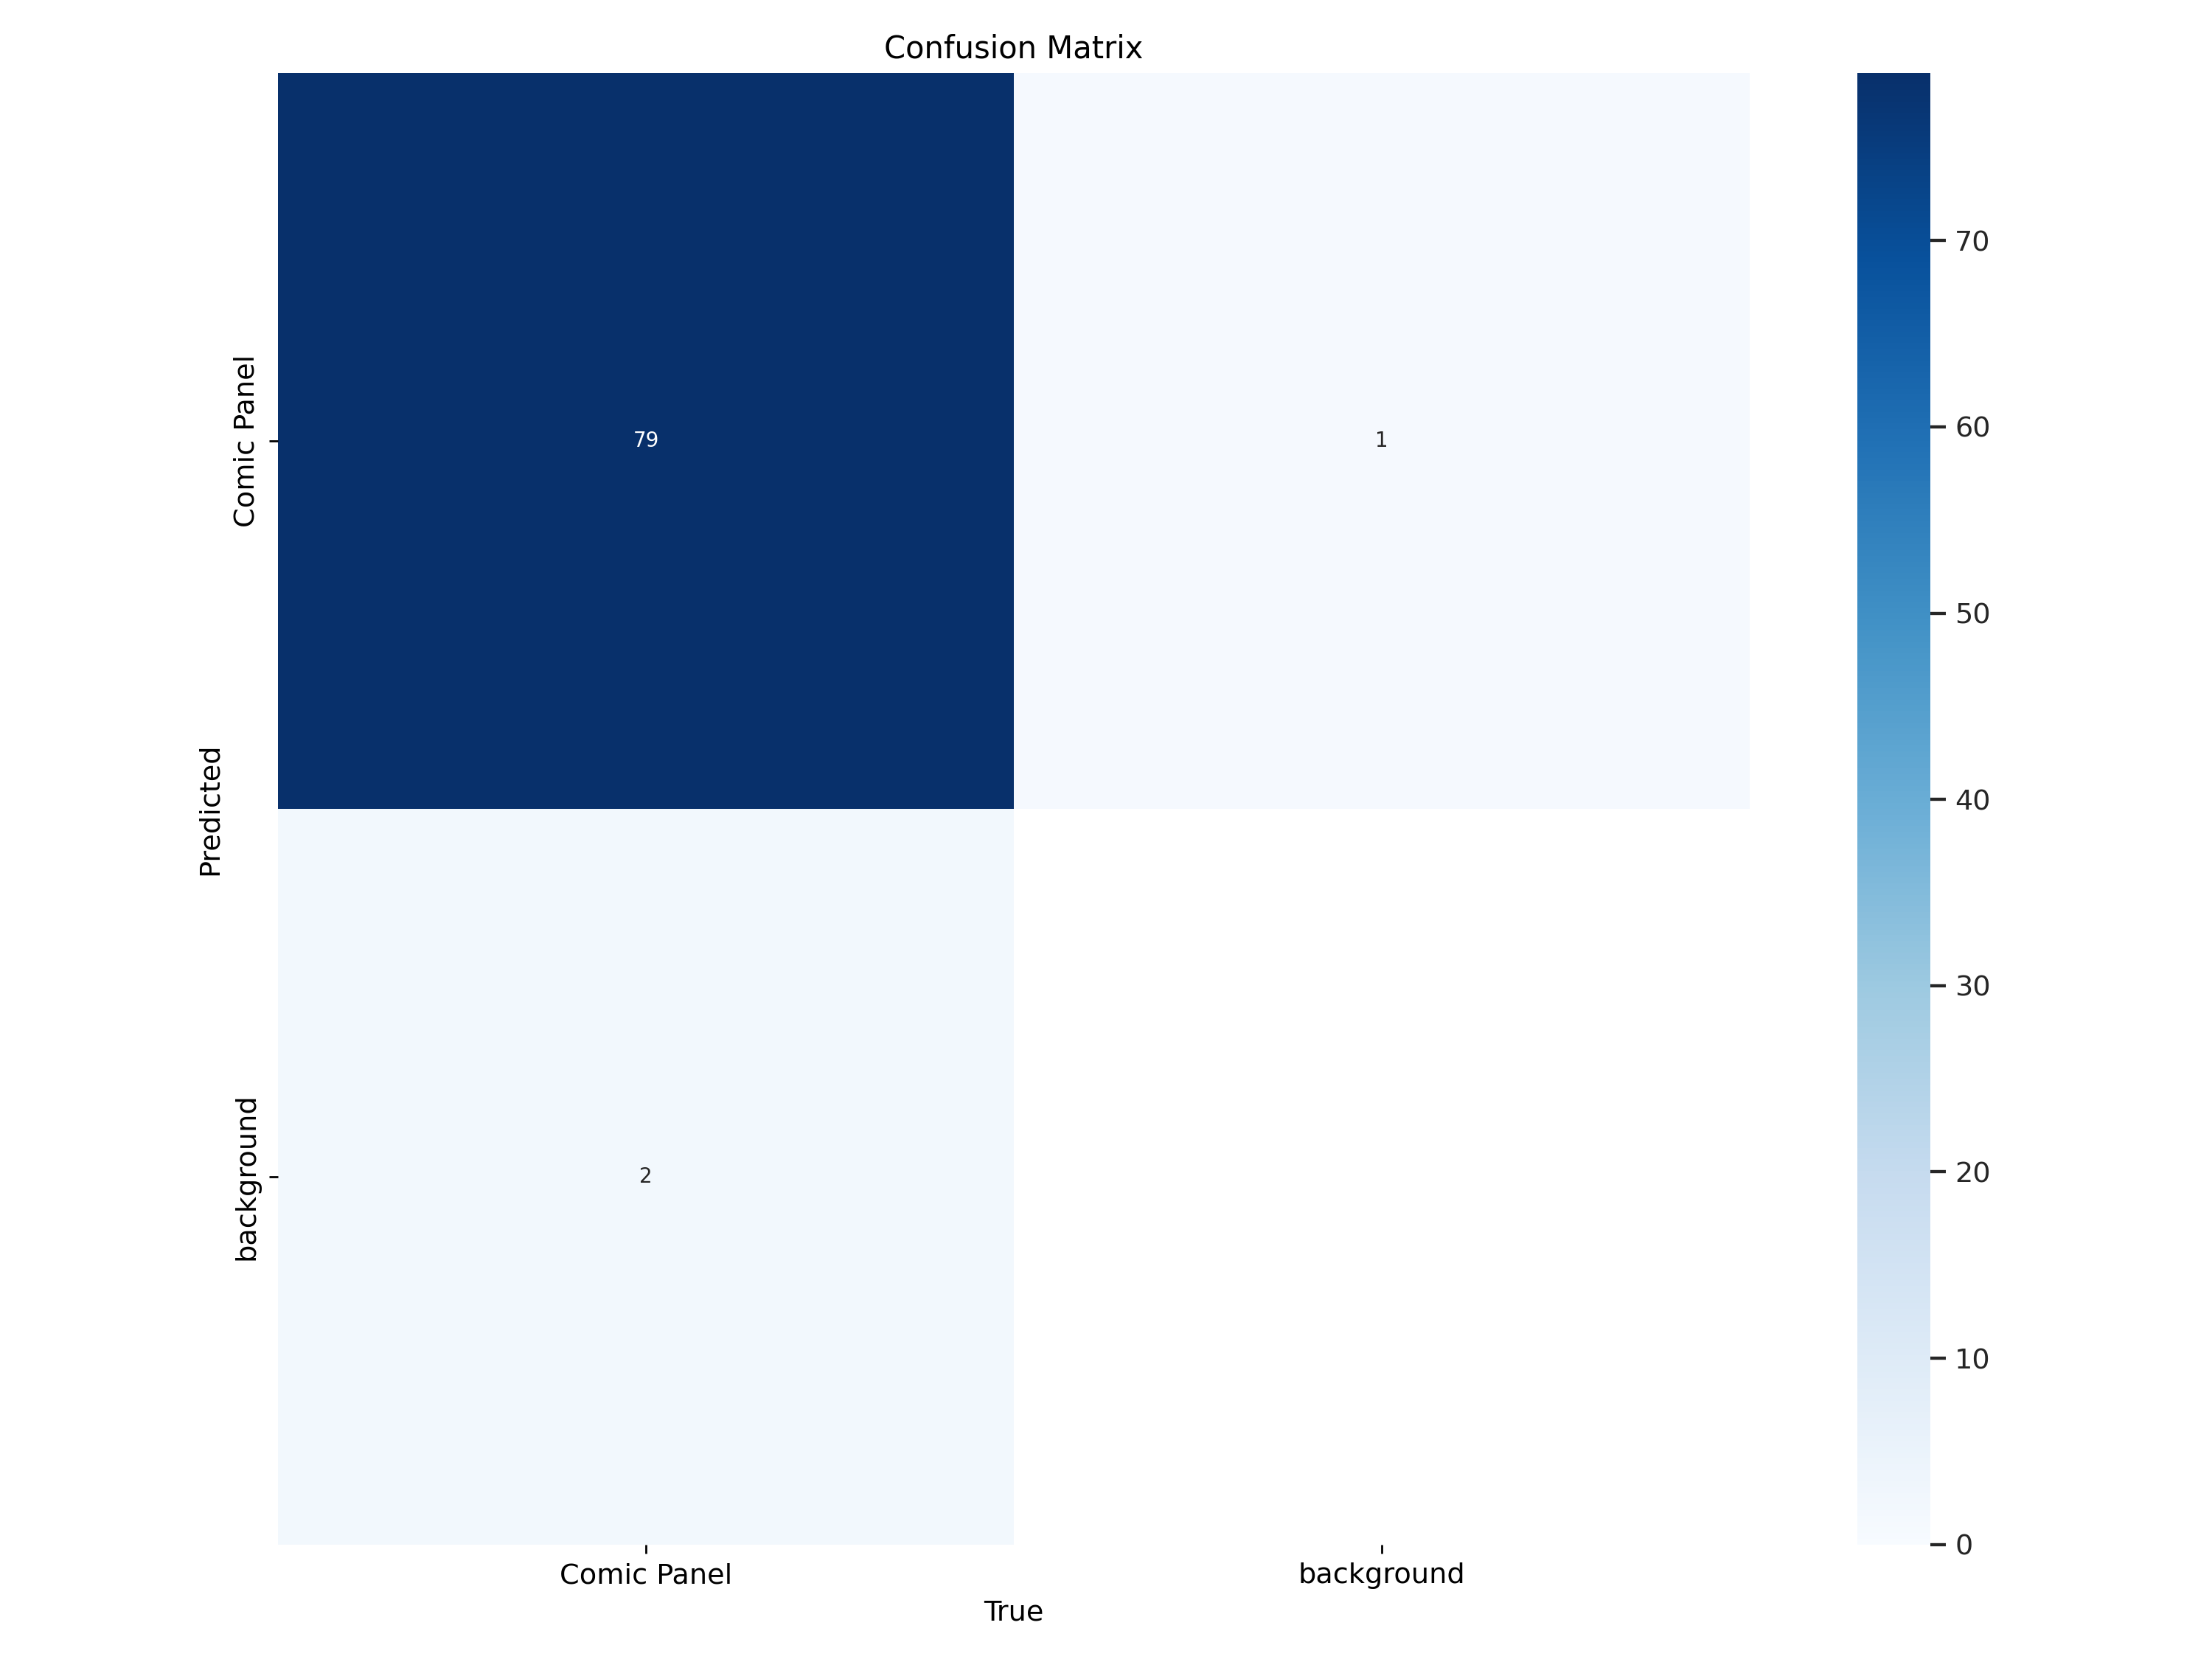

In [15]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/my_yolo_train/finetuning/confusion_matrix.png', width=600)

training and validation loss graphs

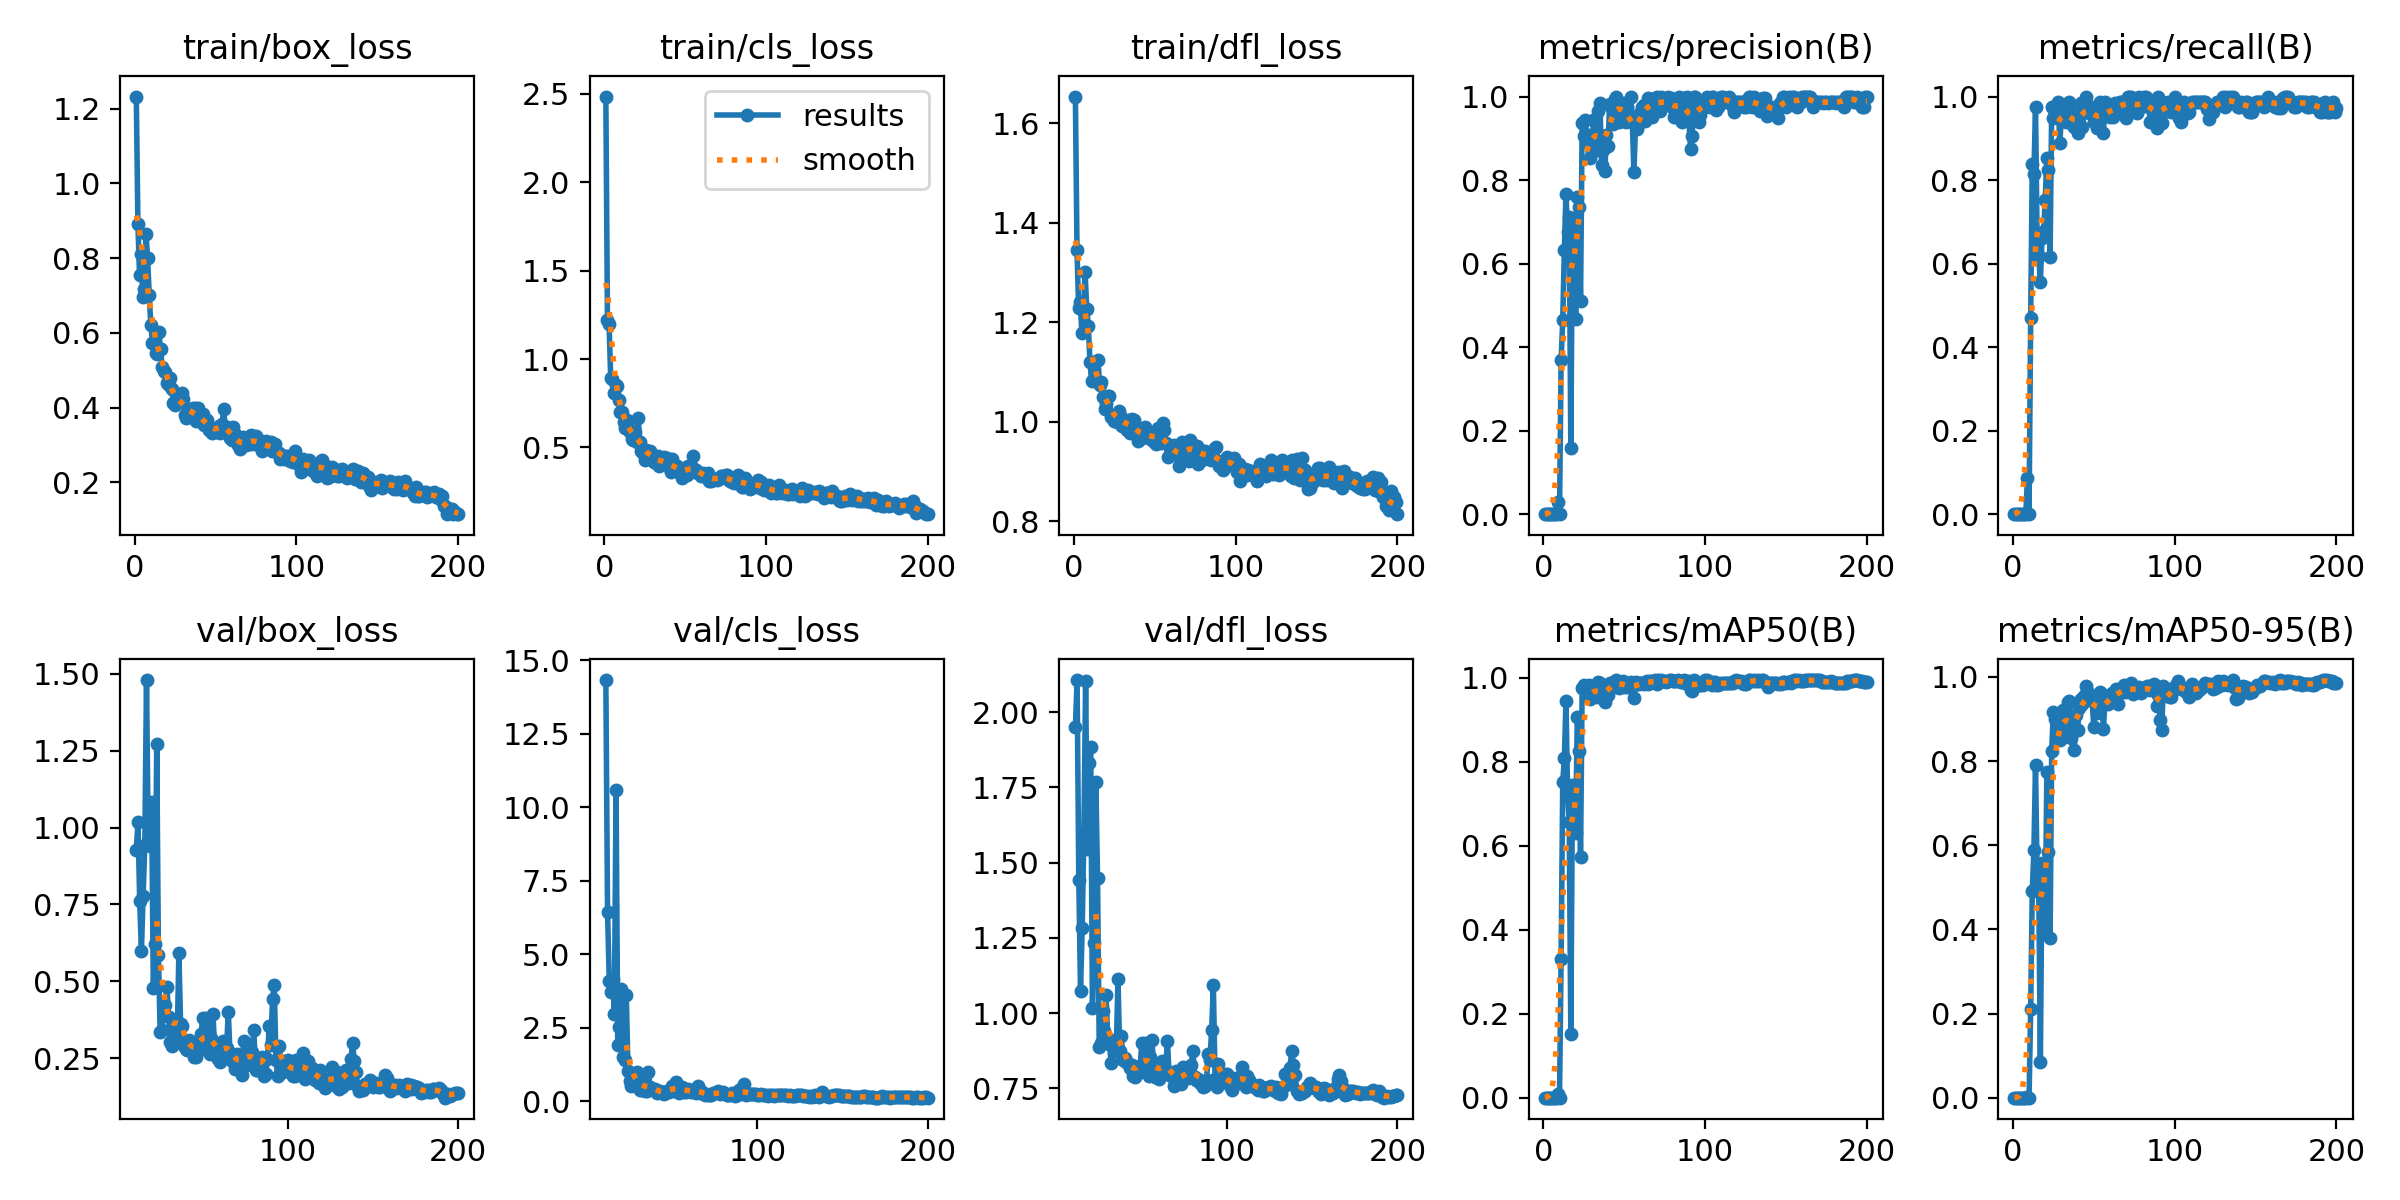

In [16]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/my_yolo_train/finetuning/results.png', width=600)

#6. Model Validation

model.val mode is used for validating a YOLO12 model after it has been trained. In this mode, the model is evaluated on a validation set to measure its accuracy and generalization performance. This mode can be used to tune the hyperparameters of the model to improve its performance.

Model Validation - Dataset Batch 0 (Predictions and Labels)




Validation Labels: 


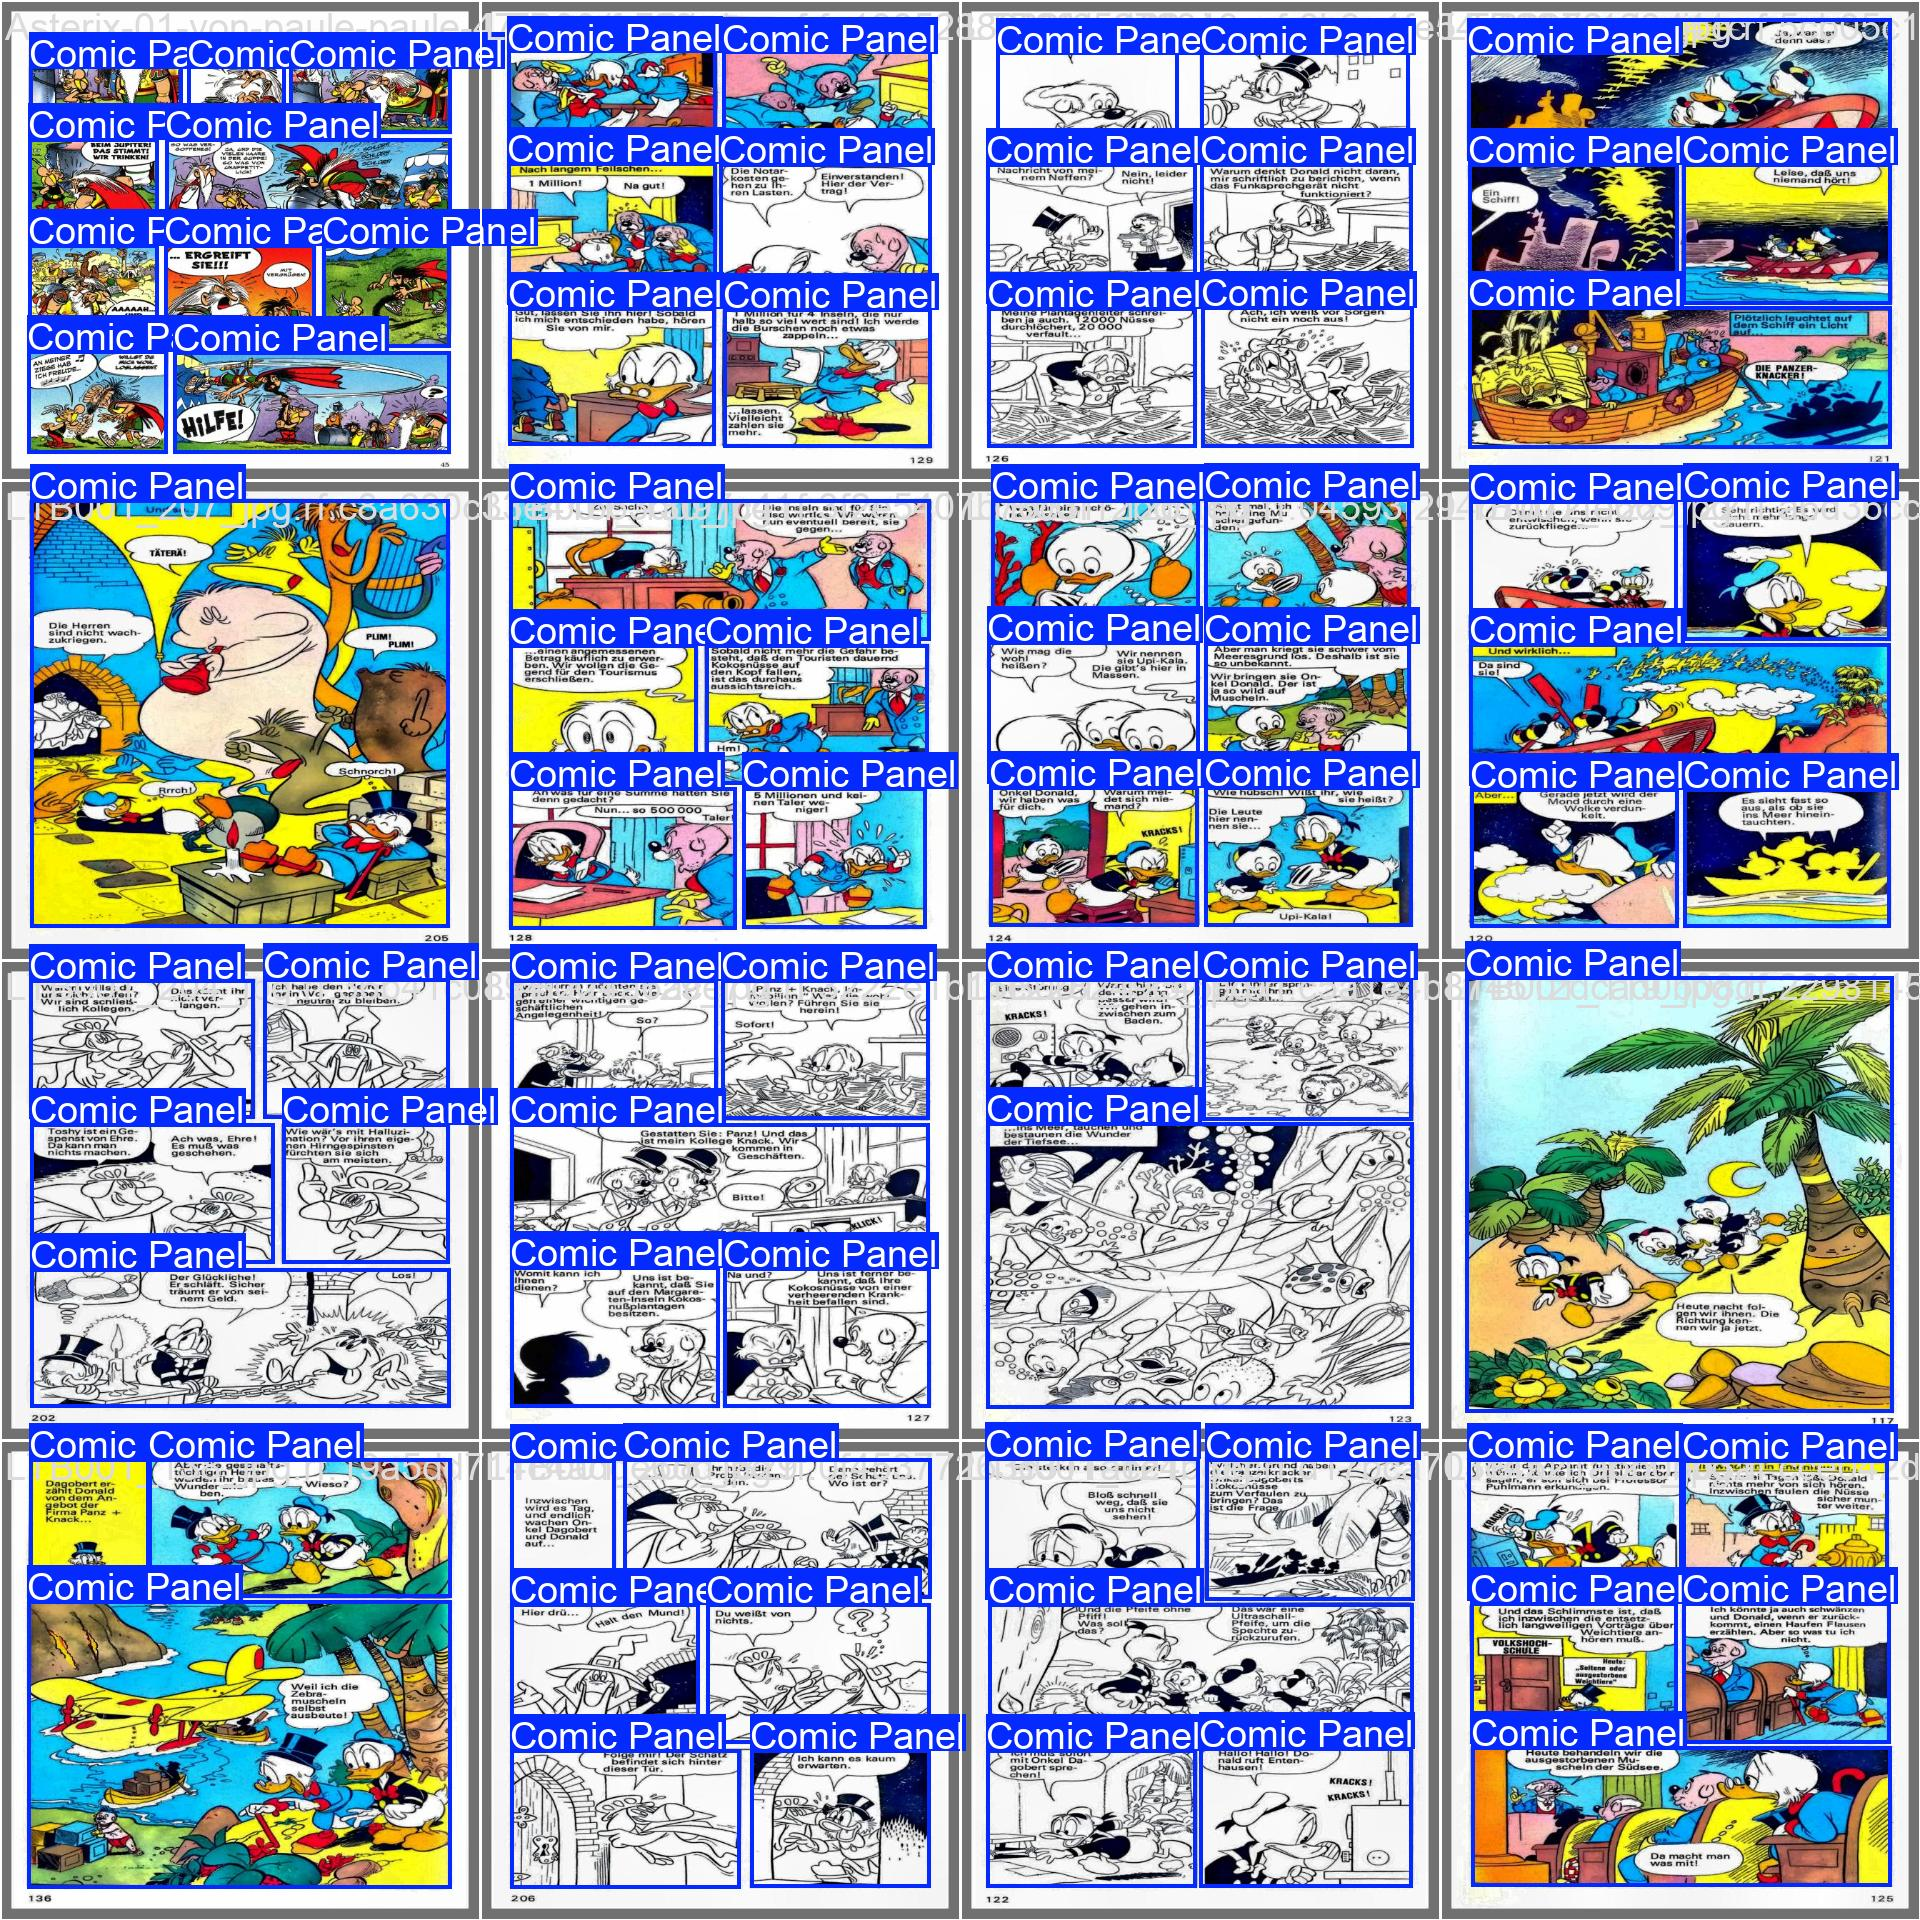

In [17]:
print("Validation Labels: ")
IPyImage(filename=f'{HOME}/my_yolo_train/finetuning/val_batch0_labels.jpg', width=600)

Validation Predictions: 


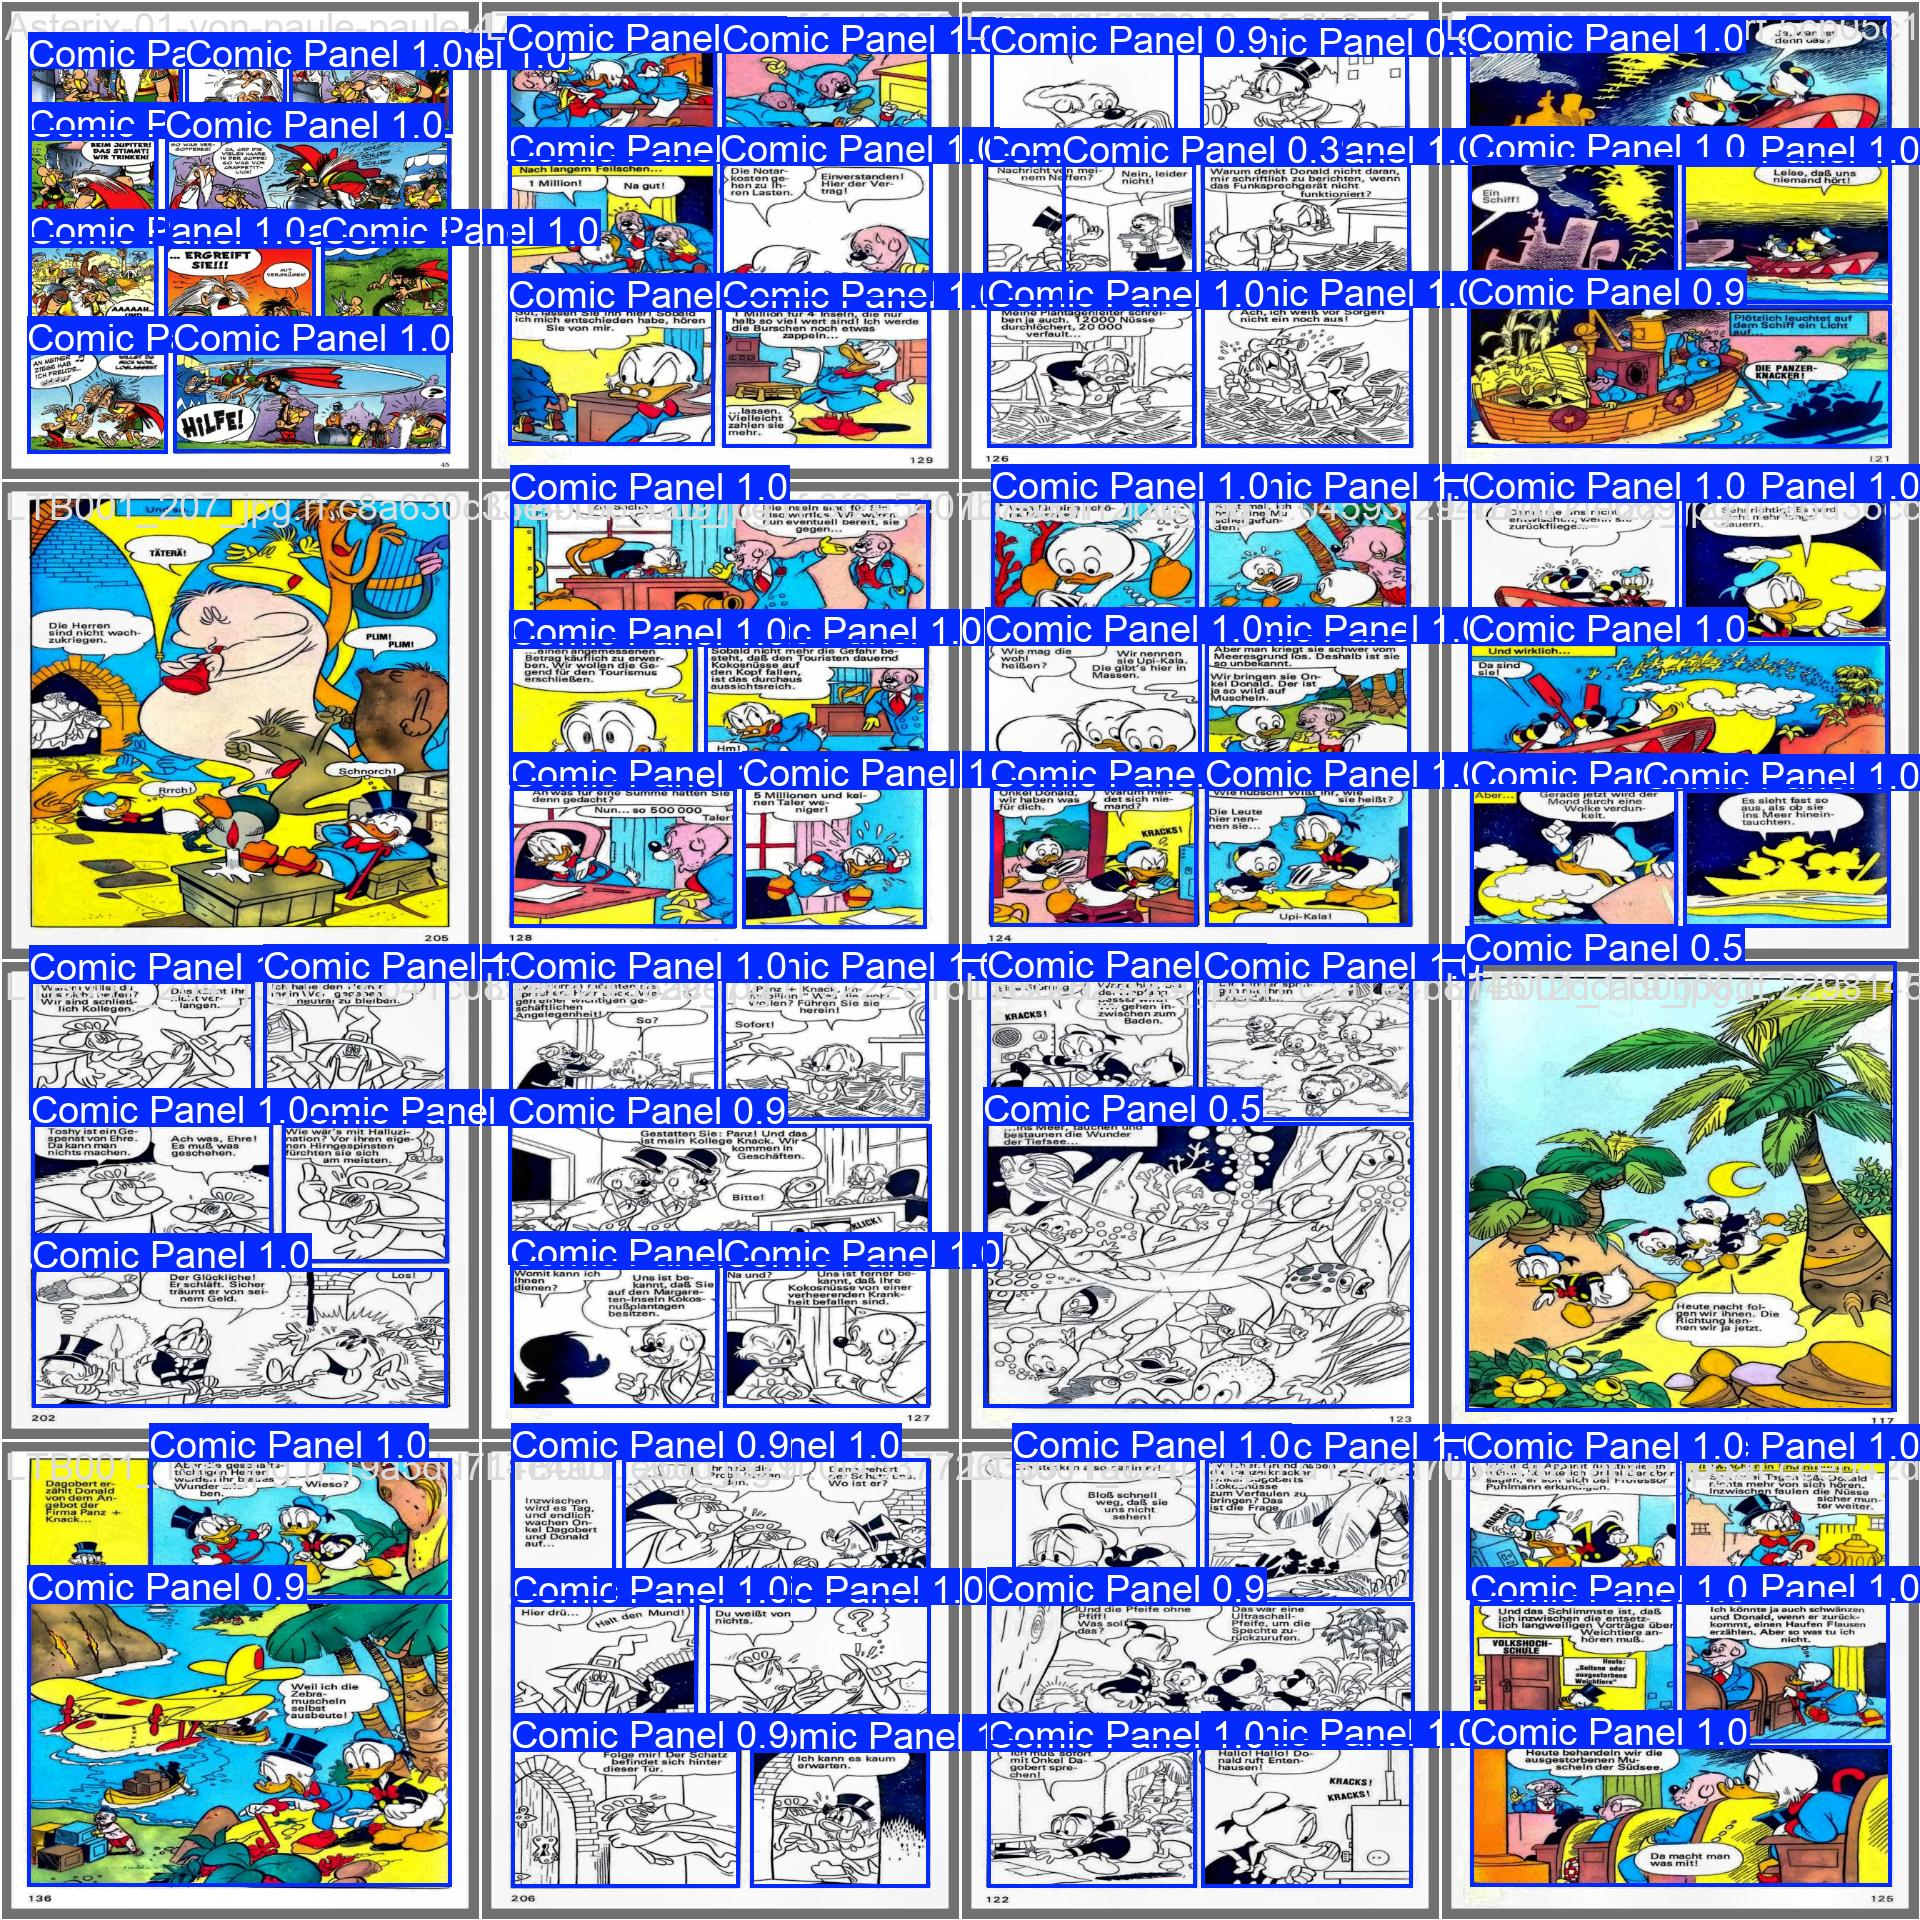

In [18]:
print("Validation Predictions: ")
IPyImage(filename=f'{HOME}/my_yolo_train/finetuning/val_batch0_pred.jpg', width=600)

start model validation

In [19]:

# Evaluate the model's performance on the validation set
last_trained_model_path = f'{HOME}/my_yolo_train/finetuning/weights/last.pt'

if os.path.exists(last_trained_model_path):
    model = YOLO(f"{HOME}/my_yolo_train/finetuning/weights/last.pt")  # load my partially trained model
    results = model.val(data=f"{dataset.location}/data.yaml", save_json=True, plots=True, project='my_yolo_train', name='validation')
else:
  results = model.val(data=f"{dataset.location}/data.yaml", save_json=True, plots=True, project='my_yolo_train', name='validation')

Ultralytics 8.3.102 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (NVIDIA GeForce RTX 3090, 24253MiB)
YOLOv12x summary (fused): 283 layers, 59,044,499 parameters, 0 gradients, 198.5 GFLOPs


val: Scanning /workspace/datasets/Custom-Workflow-3-Object-Detection-1/valid/labels.cache... 17 images, 0 backgrounds, 0 corrupt: 100%|██████████| 17/17 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


                   all         17         81          1      0.974      0.991      0.985
Speed: 1.7ms preprocess, 51.8ms inference, 0.0ms loss, 0.5ms postprocess per image
Saving my_yolo_train/validation/predictions.json...
Results saved to my_yolo_train/validation


#Predict
Here, predictions are made using the finetuned YOLO12 model on new a image.

In [22]:
import os
import random

# Image directory
image_dir = f"{dataset.location}/test/images"
files = os.listdir(image_dir)

# Filter only image files (optional, based on file extensions like .jpg, .png, etc.)
image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]

# Randomly pick an image file
input_image_name = random.choice(image_files)
input_image_path = os.path.join(image_dir, input_image_name)

# Run inference with YOLO on the first found image, specifying the save path
results = model.predict(source=input_image_path, save=True, project='my_yolo_train', name='prediction')

# Get data from the first prediction result
print(f"orig_shape: {results[0].orig_shape}")
output_image = results[0].orig_img
output_image_dir = results[0].save_dir
input_image_path = results[0].path

# Output paths
print(f"output_image_dir: {output_image_dir}")
print(f"input_image_path: {input_image_path}")
print(f"results: {results}")
print(f"Saved to: f{os.path.join(output_image_dir, input_image_name)}")



image 1/1 /workspace/datasets/Custom-Workflow-3-Object-Detection-1/test/images/LTB001_247_jpg.rf.2b6fef98840c5669845b035be2179161.jpg: 640x640 6 Comic Panels, 48.6ms
Speed: 12.8ms preprocess, 48.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
Results saved to my_yolo_train/prediction
orig_shape: (640, 640)
output_image_dir: my_yolo_train/prediction
input_image_path: /workspace/datasets/Custom-Workflow-3-Object-Detection-1/test/images/LTB001_247_jpg.rf.2b6fef98840c5669845b035be2179161.jpg
results: [ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Comic Panel'}
obb: None
orig_img: array([[[228, 228, 228],
        [236, 236, 236],
        [242, 242, 242],
        ...,
        [242, 242, 242],
        [238, 238, 238],
        [236, 236, 236]],

       [[235, 235, 235],
        [242, 242, 242],
        [245, 245, 245],
        ...,
        [244, 244, 244],
        [240, 24

Trying to load image from: my_yolo_train/prediction/LTB001_247_jpg.rf.2b6fef98840c5669845b035be2179161.jpg


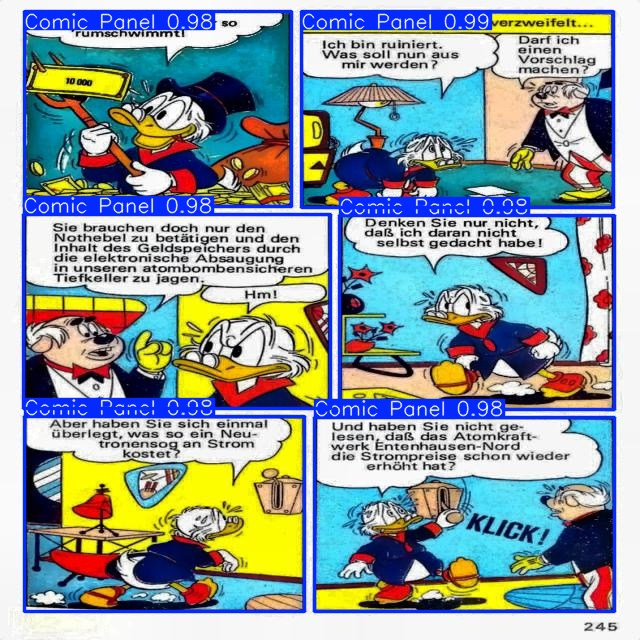

In [23]:
from IPython.display import Image as IPyImage

# Display the image
output_image_path = os.path.join(output_image_dir, input_image_name)
print(f"Trying to load image from: {output_image_path}")
IPyImage(filename=output_image_path, width=600)
